## LinearSoftmax model (LS) - Ver0

* LinearSoftmax model (LS) - VGG16 transfer learning approach on ImageNet data with linearsoftmax classfier
* Training and testing on NIOSH nanocarbon dataset with 4000+ TEM images, achieved 85% on 4-class

### Python Lib Version List (tested and recommended, other latest version may works as well)
* Python 3.6.8
* Numpy 1.16.2
* Matplotlib 3.0.2
* Scipy 1.2.1
* Keras 2.2.4
* Scikit-image 0.14.2
* Scikit-learn 0.20.2
* seaborn 0.10.0
* Pillow 5.4.1

In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imresize, bytescale, imsave
from skimage.color import gray2rgb

import keras.backend as K
from keras.models import Model
from keras.applications import vgg16

from keras.layers import Input, Dense
from keras import optimizers

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from random import shuffle

from PIL import Image

import time

Using TensorFlow backend.


### Func1 - Loading the training images
* target folder - data directory of the project, placed under the same root directory of this notebook, named as 'data_folder'
* class_folder - categorical folder under data directory, placed under target_folder, named by each individual CNT class
* num_images & num_training - total num of data and training portion control (here we set 80% train + 20% test/validation)

In [2]:
def load_NIOSH(filenames_path):
    #load images from paths specified in filenames to a np array
    #preprocess the images for vgg
    label_dict = dict()
    label_dict['CNT-Cluster'] = [1, 0, 0, 0]
    label_dict['CNT-fiber'] = [0, 1, 0, 0]
    label_dict['CNT-Matrix'] = [0, 0, 1, 0]
    label_dict['CNT-MatrixSurface'] = [0, 0, 0, 1]

    target_folder = 'data_folder'
    class_folders = ['CNT-Cluster', 'CNT-fiber', 'CNT-Matrix', 'CNT-MatrixSurface']

    # 80%train+20%test
    num_images = [848, 848, 848, 848]
    num_training = [678, 678, 678, 678]

    filenames = open(filenames_path, 'r')
    filenames_list = filenames.readlines()
    filenames.close()

    images = []
    image_labels = []
    for filename in filenames_list:
        filename = filename.strip()
        label_key = os.path.split(filename)[0] 
        image = io.imread(os.path.join(target_folder, filename))
        #preprocess the image for vgg16
        image = imresize(image, (224, 224))
        image = gray2rgb(image)
        label = label_dict[label_key]
        images.append(image)
        image_labels.append(label)
    return vgg16.preprocess_input(np.array(images)), np.array(image_labels)

### Func2&3 - vgg16 transfer learning + linearsoftmax classifier
* Vgg16 from Keras, pre-trained weights transfer from ImageNet
* Defined linearsoftmax layer as classifier with controlled output num of classes

In [3]:
#extract vgg features
def vgg_model(output_layer='fc2'):
    cnn = vgg16.VGG16(include_top=True, weights='imagenet')
    model = Model(inputs=cnn.input, outputs=cnn.get_layer(output_layer).output)
    return model

In [4]:
#linear softmax layer that uses the vgg features to classify the images
def linear_softmax_classifier(n_classes=4, input_dim=4096): # num of classes
    input_layer = Input(shape=(input_dim,))
    output_layer = Dense(n_classes, input_shape=(input_dim,), activation='softmax')(input_layer)
    return Model(inputs=input_layer, outputs=output_layer)

### Func4 - run
* Randomly selected train/test set from data directory
* Intermediate files: 
    - train/test_list: text file of train/test image names
    - train/test_images: np array of train/test image names
    - train/test_labels: np array of train/test image label
    - train/test_features: np array of train/test feature after vgg16
* vgg16+LS returns predicted label as pred
* Draw confusion matrix and t-SNE after prediction as optimization and visualization on result

In [5]:
def run(num_epoch):
    target_folder = 'data_folder'
    class_folders = ['CNT-Cluster', 'CNT-fiber', 'CNT-Matrix', 'CNT-MatrixSurface']
    # 80%train+20%test
    num_images = [848, 848, 848, 848]
    num_training = [678, 678, 678, 678]

    train_list = open('train.txt', 'w')
    test_list = open('test.txt', 'w')
    for i, class_folder in enumerate(class_folders):
        filenames = os.listdir(os.path.join(target_folder, class_folder))
        #get a random shuffle of the filenames
        shuffle(filenames)
        for j in range(num_images[i]):
            if j < num_training[i]:
                train_list.write(os.path.join(class_folder, filenames[j]) + '\n')
            else:
                test_list.write(os.path.join(class_folder, filenames[j]) + '\n')
    train_list.close()
    test_list.close()

    test_images, test_labels = load_NIOSH('test.txt')
    train_images, train_labels = load_NIOSH('train.txt')

    np.save('test_images.npy', test_images)
    np.save('test_labels.npy', test_labels)
    np.save('train_images.npy', train_images)
    np.save('train_labels.npy', train_labels)

    test_labels = np.load('test_labels.npy')
    train_labels = np.load('train_labels.npy')

    features = vgg_model()
    test_features = features.predict(test_images, verbose=True, batch_size=1)
    train_features = features.predict(train_images, verbose=True, batch_size=1)

    np.save('test_features_fc2.npy', test_features)
    np.save('train_features_fc2.npy', train_features)

    test_features = np.load('test_features_fc2.npy')
    train_features = np.load('train_features_fc2.npy')

    #create a softmax classifier for the feature data, and train / eval on the test data
    lsm = linear_softmax_classifier()
    opt = optimizers.Adam(lr=0.001)
    lsm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    lsm.fit(train_features, train_labels, epochs=num_epoch, batch_size=1, verbose=2)
    train_loss, train_acc = lsm.evaluate(train_features, train_labels, verbose=1, batch_size=1)
    test_loss, test_acc = lsm.evaluate(test_features, test_labels, verbose=1, batch_size=1)
    pred = lsm.predict(test_features, verbose=1, batch_size=1)

    #round the predicted matrix to ensure binary values, then take the argmax
    #to retrieve the original classes, where the indexes follow dict_labels above
    conf = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(np.round(pred), axis=1))
    sns.set(style='white')
    sns.heatmap(np.round(conf, decimals=2), annot=True, square=True, mask=(conf == 0), 
                cmap="viridis", xticklabels=['Cl', 'Fi', 'Ma', 'MS'], 
                yticklabels=['Cl', 'Fi', 'Ma', 'MS'])
    plt.savefig('confusion_matrix_VGG.png')
    im = Image.open('confusion_matrix_VGG.png')
    display(im)
    plt.clf()
    print("saved confusion matrix")

    # calculate percentage of class
    total_num = pred.shape[0]
    class_prob = []
    for test_class, class_name in zip(conf, class_folders):
        prob = np.sum(test_class) / total_num
        class_prob.append(prob)
        print("Testset contains Class {} images with percentage:{:.2%}".format(class_name, prob))

    # make a normalized matrix
    conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    # calculate precision for 5 classes and total precision
    precision = []
    for i in range(len(class_folders)):
        precision.append(conf[i, i])
        print("Accuracy for class {}: {:.2%}".format(class_folders[i], conf[i, i]))
    print("The total accuracy: {:.2%}".format(np.dot(class_prob, np.transpose(precision))))

    #create the confusion matrix graphic (it's kind of ugly - figure out how to make this better)
    sns.set(style='white')
    sns.heatmap(np.round(conf, decimals=2), annot=True, square=True, mask=(conf == 0), 
                cmap="viridis", xticklabels=['Cl', 'Fi', 'Ma', 'MS'], 
                yticklabels=['Cl', 'Fi', 'Ma', 'MS'])
    plt.savefig('confusion_matrix_norm_VGG.png')
    im = Image.open('confusion_matrix_norm_VGG.png')
    display(im)
    plt.clf()
    print("saved normalized confusion matrix")

    #create a tSNE plot from the vgg features, using PCA to reduce to 50 dimensions first
    all_features = np.append(train_features, test_features, axis=0)
    all_labels = np.append(train_labels, test_labels, axis=0)
    label_indices = np.argmax(all_labels, axis=1)
    pca = PCA(n_components=50)
    reduced_features = pca.fit_transform(all_features)
    tsne = TSNE(n_components=2, perplexity=30)
    two_dim_features = tsne.fit_transform(reduced_features)

    classes = ['Cl', 'Fi', 'Ma', 'MS']
    colors = ['r', 'y', 'g', 'c']

    c = []
    x = []
    y = [] 
    for i in range(len(label_indices)):
        c.append(colors[label_indices[i]])
        x.append(two_dim_features[i, 0])
        y.append(two_dim_features[i, 1])
    c = np.array(c)
    x = np.array(x)
    y = np.array(y)
    plt.scatter(x, y, c=c)

    #create the legend for the plot, using rectangles
    recs = []
    for i in range(len(classes)):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))
    plt.legend(recs, classes)
    plt.savefig('tsne_VGG.png')
    im = Image.open('tsne_VGG.png')
    display(im)
    plt.clf()
    print("saved tsne image")

    #Try using pil to make tSNE instead
    plot = Image.new('L', (800, 800))

    #convert the tSNE to fit into the 800x800 space, from 100-700
    x_min, x_max = np.min(x), np.max(x)
    x_range = x_max - x_min
    y_min, y_max = np.min(y), np.max(y)
    y_range = y_max - y_min

    x = ((x - x_min) * 600 / x_range) + 100
    #invert the y coordinates, since origin is top left
    y = 800 - (((y - y_min) * 600 / y_range) + 100)

    #read in the all of the images as one list that is the same as the tSNE list
    filenames_train = open('train.txt', 'r')
    filenames_train_list = filenames_train.readlines()
    filenames_test = open('test.txt', 'r')
    filenames_test_list = filenames_test.readlines()

    filenames_train.close()
    filenames_test.close()

    filenames_list = filenames_train_list + filenames_test_list

    for i, filename in enumerate(filenames_list):
        filename = filename.strip()
        x_i = x[i]
        y_i = y[i]
        img = Image.open(os.path.join(target_folder, filename))
        img = img.convert(mode='L')
        img = img.resize((40, 40))
        plot.paste(img, box=(int(x_i), int(y_i)))
    plot.save('tSNE_images_fc2_50.jpeg')
    im = Image.open('tSNE_images_fc2_50.jpeg')
    display(im)
    print("saved tSNE PIL image")
    return train_acc, test_acc

In [6]:
def main():
    print("Please set number of epoch to learn:")
    start_epoch = int(input())
    # print("Please set the maxmum number of epoch to learn:")
    # end_epoch = int(input())

    localtime = time.asctime( time.localtime(time.time()) )
    start = time.time()
    print("Program Started: {}".format(localtime))

    for j in range(1):
        train_acc_list = []
        validation_acc_list = []
        epochs = []

        i = start_epoch
        train_acc, validation_acc = run(i)
        print("Epoch: {},\tTrain acc: {:.2%}".format(i, train_acc))
        print("Epoch: {},\tTest acc: {:.2%}".format(i, validation_acc))
        train_acc_list.append(round(train_acc*100, 2))
        validation_acc_list.append(round(validation_acc*100, 2))
        epochs.append(i)
    print(epochs)
    print(train_acc_list)
    print(validation_acc_list)

    # counting time
    print("Program ended: {}".format(localtime))
    end = time.time()
    print("This progress takes {} minutes to run!".format((end-start)/60))

### Casual Error for cudnn

* Somethings appear as CuDNN failed to initialize. Simply reboot the system will help.

*UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node block1_conv1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block1_conv1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, block1_conv1/kernel/read)]]
	 [[{{node fc2/Relu/_199}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_166_fc2/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]*

Please set number of epoch to learn:
50
Program Started: Mon Jun  1 14:45:41 2020


E:\Tools\Anaconda\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


2712/2712 [==============================] - 21s 8ms/step
Epoch 1/50
 - 4s - loss: 1.4838 - acc: 0.7231
Epoch 2/50
 - 4s - loss: 1.1716 - acc: 0.8289
Epoch 3/50
 - 4s - loss: 1.0011 - acc: 0.8525
Epoch 4/50
 - 4s - loss: 0.8055 - acc: 0.8798
Epoch 5/50
 - 4s - loss: 0.7382 - acc: 0.9012
Epoch 6/50
 - 4s - loss: 0.6250 - acc: 0.9115
Epoch 7/50
 - 4s - loss: 0.5846 - acc: 0.9156
Epoch 8/50
 - 4s - loss: 0.4804 - acc: 0.9322
Epoch 9/50
 - 4s - loss: 0.3995 - acc: 0.9428
Epoch 10/50
 - 4s - loss: 0.4366 - acc: 0.9369
Epoch 11/50
 - 4s - loss: 0.3534 - acc: 0.9499
Epoch 12/50
 - 4s - loss: 0.3365 - acc: 0.9491
Epoch 13/50
 - 4s - loss: 0.3281 - acc: 0.9521
Epoch 14/50
 - 4s - loss: 0.3287 - acc: 0.9565
Epoch 15/50
 - 4s - loss: 0.3152 - acc: 0.9554
Epoch 16/50
 - 4s - loss: 0.2820 - acc: 0.9609
Epoch 17/50
 - 4s - loss: 0.2865 - acc: 0.9609
Epoch 18/50
 - 4s - loss: 0.2116 - acc: 0.9683
Epoch 19/50
 - 4s - loss: 0.2534 - acc: 0.9683
Epoch 20/50
 - 4s - loss: 0.2365 - acc: 0.9694
Epoch 21/50

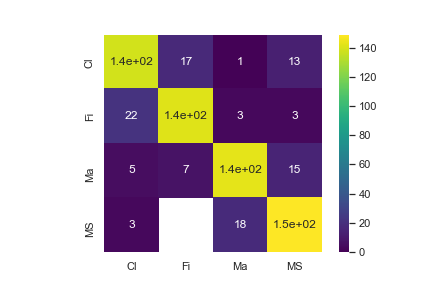

saved confusion matrix
Testset contains Class CNT-Cluster images with percentage:25.00%
Testset contains Class CNT-fiber images with percentage:25.00%
Testset contains Class CNT-Matrix images with percentage:25.00%
Testset contains Class CNT-MatrixSurface images with percentage:25.00%
Accuracy for class CNT-Cluster: 81.76%
Accuracy for class CNT-fiber: 83.53%
Accuracy for class CNT-Matrix: 84.12%
Accuracy for class CNT-MatrixSurface: 87.65%
The total accuracy: 84.26%


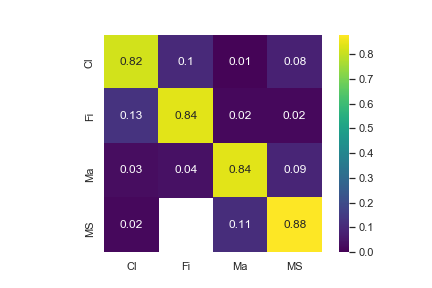

saved normalized confusion matrix


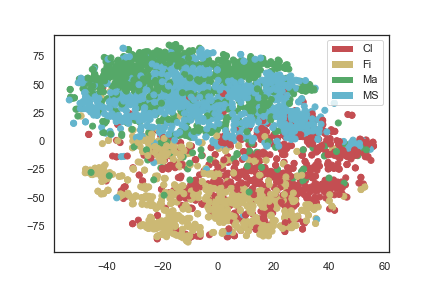

saved tsne image


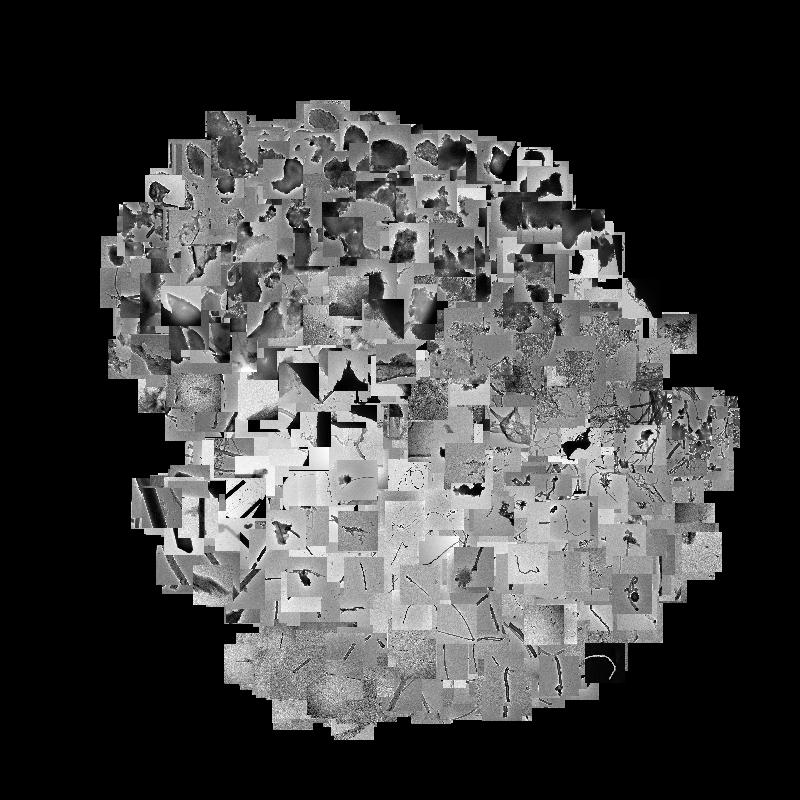

saved tSNE PIL image
Epoch: 50,	Train acc: 99.52%
Epoch: 50,	Test acc: 84.26%
[50]
[99.52]
[84.26]
Program ended: Mon Jun  1 14:45:41 2020
This progress takes 6.954225599765778 minutes to run!


<Figure size 432x288 with 0 Axes>

In [8]:
if __name__ == '__main__':
    main()